Recipe for peak-fitting in a way that handles Bayesian block boundary effects

In [65]:
from xrdc.recipes import T_progression

(0, 0)
Peak at 69, start iteration with error = 0.009490582932913348
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 22

Peak at 276, start iteration with error = 0.007011101252945293
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 

1
0.00010395481055531716
0.00010395481055531716
{'linkage': 'ward', 'affinity': 'euclidean'}


/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/featurization.py:249: RuntimeWarning: invalid value encountered in true_divide
  similarity = np.dot(composition, composition.T) / np.outer(norm, norm)


<module 'xrdc.recipes.T_progression' from '/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/recipes/T_progression.py'>

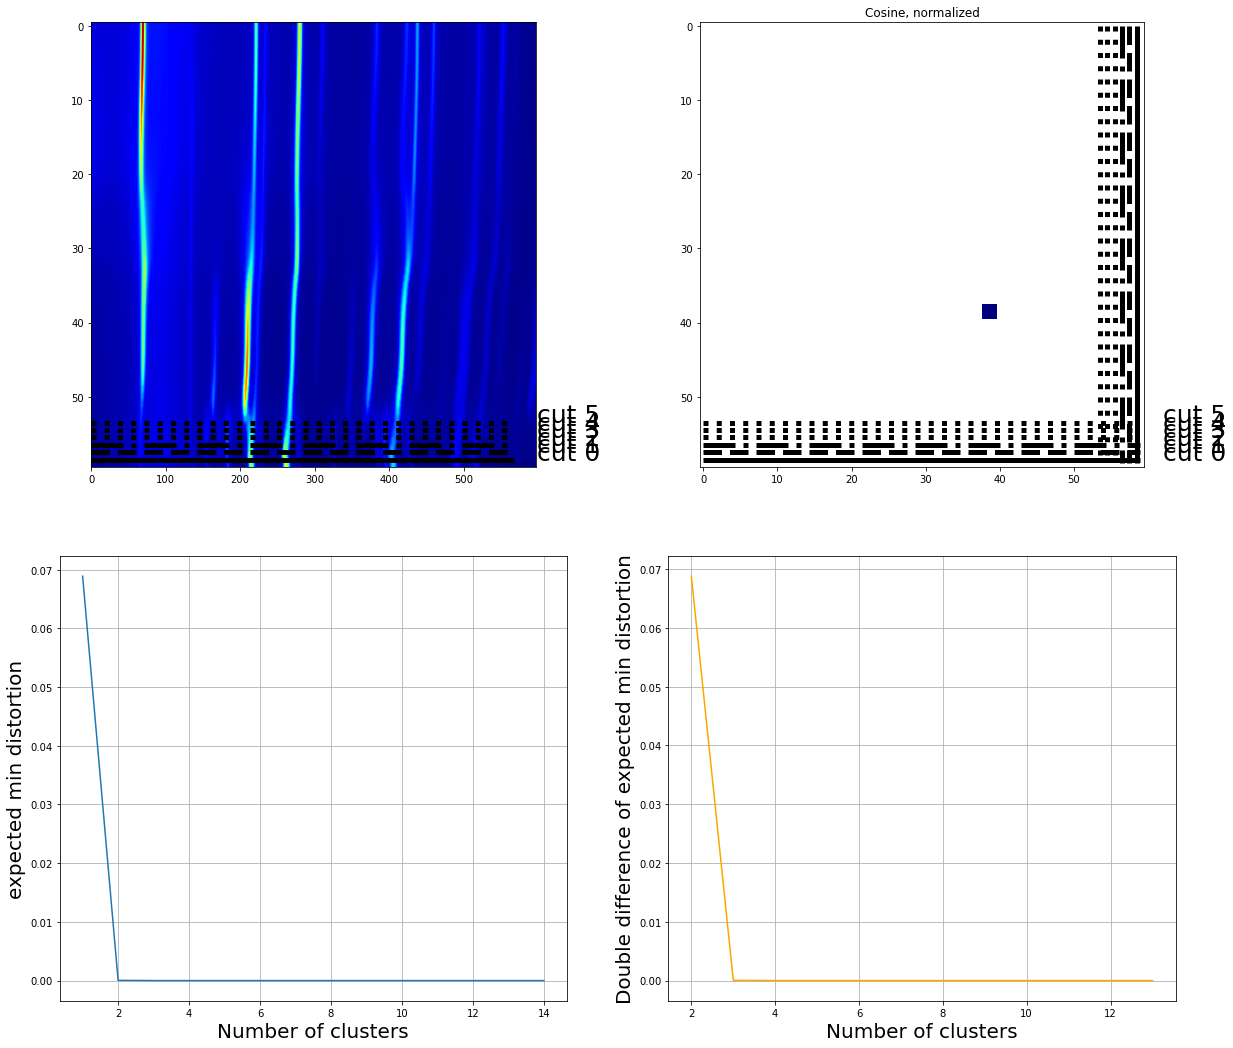

In [191]:
reload(T_progression)

In [247]:
# TODO normalization needs to be baked in

fsub_stop_2d = T_progression.fsub_stop_2d
patterns = T_progression.patterns
background = T_progression.background
fast_q = T_progression.fast_q
fast_T = T_progression.fast_T

scale = 1 / (1 * fast_q.mean())
patterns *= scale

background *= scale
fast_T *= scale
fast_q *= scale
noise = fast_T

In [248]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload

from xrdc import xrdutils
from xrdc import source_separation as sep
from xrdc import featurization as feat
from xrdc import visualization as vis
from xrdc import peak_fitting as pf
from xrdc import workflows
from xrdc import geometry
from xrdc import plotting
from xrdc import refinement
from xrdc import misc

from scipy.ndimage.filters import gaussian_filter as gf
from matplotlib.pyplot import figure

from copy import deepcopy as dc

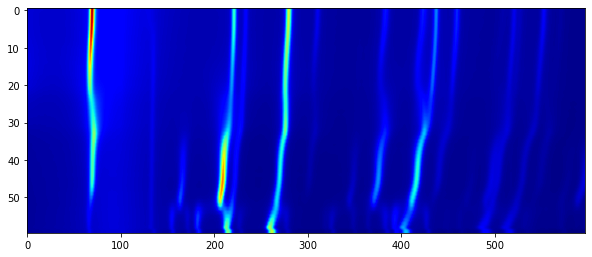

In [249]:
plt.imshow(patterns, aspect = 4, cmap = 'jet')

In [250]:
fast_q.mean() 

1.0

In [251]:
%matplotlib inline
sep.iplot_rows(patterns, fast_q, background, labels = ['raw', 'extracted'])

interactive(children=(IntSlider(value=29, description='i', max=59), Output(layout=Layout(height='550px'))), _d…

In [253]:
def mean2d(arr2d):
    return arr2d.mean(axis = 0)[:, None].T

In [254]:
def restrict_range(fitlists_merged, fitlists_single, offset = 1, clip = True):
    suby, _, noiseListNew, xListNew, yListNew, _ = fitlists_single
    _, summaryList, _, _, _, curve_paramsList = fitlists_merged
    
    def take(arr):
        if clip:
            return np.array(misc.deepmap(arr, lambda arr: arr[offset:-offset], 1))
        else:
            return np.array(arr)#misc.deepmap(arr, lambda arr: arr, 1))
    return suby, summaryList, take(noiseListNew), take(xListNew), take(yListNew), curve_paramsList


def filter_peaks_and_restrict_range(fitlists_merged, fitlists_single, bounds, i, offset = 1, clip_edges = True):
    filt = refinement.filter_peaks(fitlists_merged, bounds, i, boundoffset = 1, buffer = 0.5, clip_edges = clip_edges)
    return restrict_range(filt, fitlists_single, clip = clip_edges)

In [255]:
from xrdc.dataproc.dataproc.operations import hitp

In [346]:
stdratio_threshold = .5

def curvefit_refine(pattern, background, overlap = 3, reg_scale = 1e-1, smooth_bba = 1.5):
    """

    """

    ### TODO refactor so that this function only accepts data with sample dimension == 1
    assert len(pattern.shape) == 1

    x = np.arange(len(pattern))
    bounds = hitp.bayesian_block_finder(x, gf(pattern - background, smooth_bba))
    
    pattern = pattern[None, :]
    background = background[None, :]
    
    print('bounds', bounds)
    # fit_sigma = True passes the estimated uncertainty to the scipy.fit_curve
    fsub_stop_2d_1 = pf.curvefit_2d((pattern - 0), stdratio_threshold = stdratio_threshold,\
                                    noise_estimate = noise, background = (background),\
                                    bg_shift_pos = True, fit_sigma = True, reg_scale = reg_scale, reg_edge = 0,
                                   bounds = bounds);

    i, j = 0, 0
    
    # Bayesian block bounds are dependent on background subtraction, so this doesn't work
#     _, _, _, _, _, bounds = pf.get_curves(fsub_stop_2d_1, i, j, peak_range_only=False)

    fsub_stop_2d_1_filt = refinement.filter_peaks(fsub_stop_2d_1, bounds, 0, boundoffset = 0, buffer= .5,
                                                 clip_edges = False)

    # TODO debug
#     fsub_stop_2d_3 = pf.merge_fitoutput_blocks(fsub_stop_2d_1_filt, overlap = overlap)
#     fsub_stop_2d_3 = pf.refine_2d((pattern - background),
#                         pf.merge_fitoutput_blocks(fsub_stop_2d_1_filt, overlap = overlap),\
#                         noise_estimate = noise, background = None,\
#                         bg_shift_pos = True, fit_sigma = True, reg_scale = reg_scale, reg_edge = 0,
#                         overlap = overlap, bounds = bounds)

#     fsub_stop_2d_3_cropped = filter_peaks_and_restrict_range(fsub_stop_2d_3, fsub_stop_2d_1, bounds, i,
#                                                              clip_edges=True)
    #return fsub_stop_2d_1, fsub_stop_2d_3_cropped, bounds
    return fsub_stop_2d_1, bounds

In [343]:
%pdb

Automatic pdb calling has been turned ON


In [347]:
reload(refinement.plotting)
reload(plotting)
reload(refinement)
reload(pf.hitp)
reload(pf)

np.random.seed(42)

i = 4

# %%capture
fits_init, bounds = curvefit_refine(patterns[i], background[i], reg_scale = 1e-1)

/home/ollie/anaconda3/lib/python3.8/site-packages/xrdc-1.0-py3.8.egg/xrdc/dataproc/dataproc/workflows/basicConfig
numBlocks: 143, dataPts/Block: 4.174825174825175
bounds [  0.   9. 104. 205. 230. 269. 304. 371. 413. 431. 453. 503. 545. 596.]
[  0.   9. 104. 205. 230. 269. 304. 371. 413. 431. 453. 503. 545. 596.]
True
Experimental Info used: 

{'blockBounds_list': [[0.0, 9.0], [9.0, 104.0], [104.0, 205.0], [205.0, 230.0], [230.0, 269.0], [269.0, 304.0], [304.0, 371.0], [371.0, 413.0], [413.0, 431.0], [431.0, 453.0], [453.0, 503.0], [503.0, 545.0], [545.0, 596.0]]}
global background
[0.23908864 0.19250975 0.15312125 0.12426028 0.11158393 0.0934447
 0.06747406 0.04970304]
[0.23908864 0.19250975 0.15312125 0.12426028 0.11158393 0.0934447
 0.06747406 0.04970304]
negative values in background-subtracted pattern. shifting first percentile to zero and setting values below it to zero.
global background
[ 3.31816433e-02  3.30449810e-02  2.95130323e-02  5.31213673e-03
 -2.44329237e-02 -3.63342333

Peak at 423, start iteration with error = 0.4960083641466798
4.029133812364212
[413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 423, iteration 0: error = 0.14060325831695264
0.8722173615574089
[413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 423, iteration 1: error = 0.07375401143375668
bounds ([412.15, -1.0831149524412202, 0, 0, 0, 412.15, -1.0831149524412202, 0, 0, 0], [430.85, inf, inf, 17.0, 17.0, 430.85, inf, inf, 17.0, 17.0])
[413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430]
Peak at 438, start iteration with error = 0.3835313880808753
3.888997930314771
[431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452]
Peak at 438, iteration 0: error = 0.13439356615983464
0.6535403851226009
[431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452]
Peak at 438, iteration 1: error = 0.08524744607650143
bounds ([429.95, -2.2372489731220555

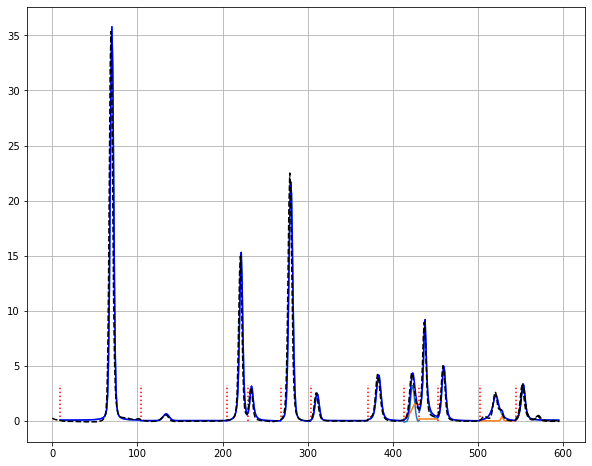

In [339]:
plotting.plot_all_fits(fits_init, 0);
#plt.plot(mean2d(patterns - background)[0], 'k--')
plt.plot((patterns - background)[i], 'k--')

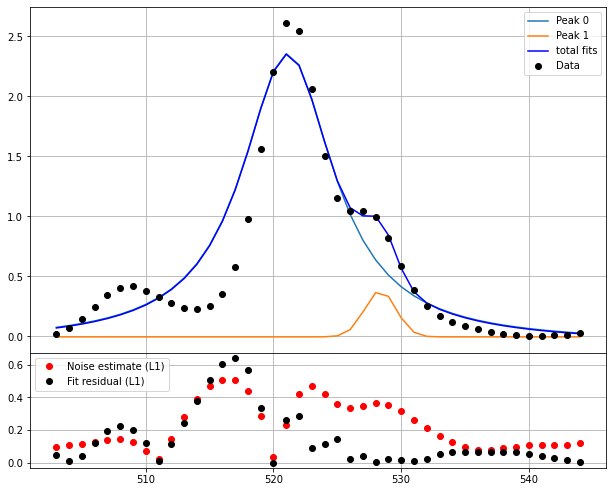

In [340]:
plotting.plot_one_fit(fits_init, 0, 10);

In [311]:
# TODO debug
# plotting.plot_one_fit(fits_refined, 0, 5);

In [312]:
# XX, YY = refinement.get_tails(fsub_stop_2d_3, bounds, 0, 1, background = background)

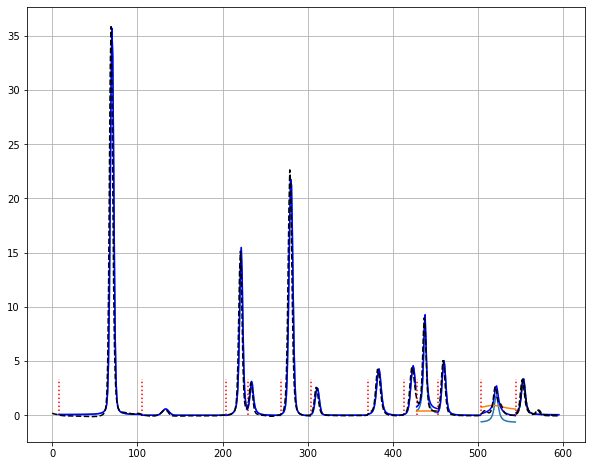

In [314]:
# plotting.plot_all_fits(fits_init, 0);
# plt.plot(mean2d(patterns - background)[0], 'k--')

(-25.0, 100.0)

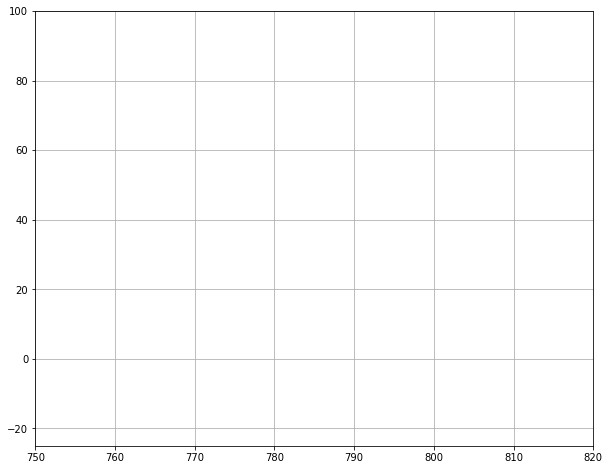

In [315]:
# # TODO offsets, range clipping
# plotting.plot_all_fits(fits_refined, 0);
# plt.plot(mean2d(patterns - background)[0], 'k--')

# plt.xlim(750, 820)
# plt.ylim(-25, 100)

In [49]:
def pad_fits(fits1, fits2, size = 1):
    def _padlist(lst1, lst2):
        return [lst2[:size]] + lst1 + [lst2[-size:]]
    res = [fits1[0]]
    for lst1, lst2 in zip(fits1[1:], fits2[1:]):
        res.append(_padlist(lst1, lst2))
    return res

# Interactive plots

interactive(children=(IntSlider(value=14, description='i', max=29), Output(layout=Layout(height='550px'))), _d…

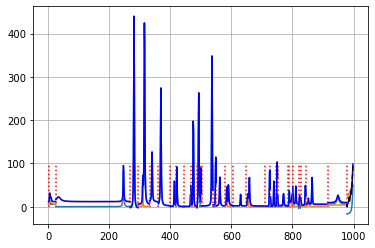

In [77]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_init, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])

interactive(children=(IntSlider(value=13, description='i', max=26), Output(layout=Layout(height='550px'))), _d…

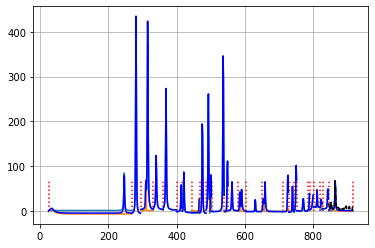

In [51]:
#40. add a difference plot
%matplotlib inline
Ys, yss = plotting.plot_all_fits(fits_refined, 0);
sep.iplot_rows(yss, Ys,
               nested_label_callback= lambda lst, idx: 'curve '+ str(idx) if idx < (len(lst) - 1) else 'fit sum',
               styles = ['-', 'k--'],
               labels = ['', 'data (background subtracted)'])